In [1]:
import cirq
import numpy as np

In [2]:
# setup random circuits
from cirq.experiments import random_quantum_circuit_generation as rqcg

circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, 
    two_qubit_gate=cirq.ISWAP**0.5,
    random_state=52,
)
print(len(circuit_library))

20


In [3]:
# We will truncate to these lengths
max_depth = 100
cycle_depths = np.arange(3, max_depth, 20)
cycle_depths

array([ 3, 23, 43, 63, 83])

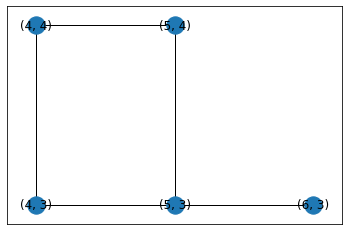

In [7]:
# determine device topology
device_name = None

import cirq.contrib.routing as ccr
import networkx as nx

if device_name is None:
    qubits = cirq.GridQubit.rect(3, 2, 4, 3)
    # Delete one qubit from the rectangular arangement to
    # 1) make it irregular 2) simplify simulation.
    qubits = qubits[:-1]
    sampler = cirq.DensityMatrixSimulator(noise=cirq.depolarize(5e-3))
    graph = ccr.gridqubits_to_graph_device(qubits)
else:
    import cirq_google as cg
    sampler = cg.get_engine_sampler(device_name, gate_set_name='sqrt_iswap')
    device = cg.get_engine_device(device_name)
    qubits = sorted(device.qubits)
    graph = ccr.gridqubits_to_graph_device(device.qubits)


pos = {q: (q.row, q.col) for q in qubits}
nx.draw_networkx(graph, pos=pos)

In [8]:
# setup combinations
combs_by_layer = rqcg.get_random_combinations_for_device(
    n_library_circuits=len(circuit_library),
    n_combinations=10,
    device_graph=graph,
    random_state=53,
)
combs_by_layer

[CircuitLibraryCombination(layer=cirq.experiments.GridInteractionLayer(col_offset=0, vertical=True, stagger=True), combinations=array([[ 5, 16],
        [12,  9],
        [ 5, 18],
        [11,  3],
        [ 6,  9],
        [13,  3],
        [11,  6],
        [14, 12],
        [16, 10],
        [18, 15]]), pairs=[(cirq.GridQubit(4, 4), cirq.GridQubit(5, 4)), (cirq.GridQubit(5, 3), cirq.GridQubit(6, 3))]),
 CircuitLibraryCombination(layer=cirq.experiments.GridInteractionLayer(col_offset=1, vertical=True, stagger=True), combinations=array([[16],
        [ 3],
        [12],
        [ 0],
        [ 5],
        [ 5],
        [ 0],
        [ 7],
        [ 9],
        [12]]), pairs=[(cirq.GridQubit(4, 3), cirq.GridQubit(5, 3))]),
 CircuitLibraryCombination(layer=cirq.experiments.GridInteractionLayer(col_offset=1, vertical=False, stagger=True), combinations=array([[13],
        [ 8],
        [ 8],
        [13],
        [ 1],
        [11],
        [11],
        [ 8],
        [14],
        [14]

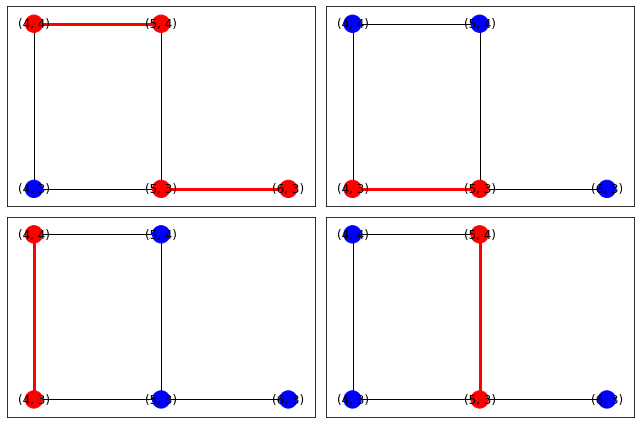

In [9]:
# visualize active pairs
%matplotlib inline
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(9,6))
for comb_layer, ax in zip(combs_by_layer, axes.reshape(-1)):
    active_qubits = np.array(comb_layer.pairs).reshape(-1)
    colors = ['red' if q in active_qubits else 'blue' for q in graph.nodes]
    nx.draw_networkx(graph, pos=pos, node_color=colors, ax=ax)
    nx.draw_networkx_edges(graph, pos=pos, edgelist=comb_layer.pairs, width=3, edge_color='red', ax=ax)

plt.tight_layout()

In [11]:
# take data
from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
    combinations_by_layer=combs_by_layer,
    shuffle=np.random.RandomState(52),
    repetitions=10_000,
)
sampled_df

100%|███████████████████████████████████████████████████████████| 207/207 [01:09<00:00,  2.97it/s]


,,sampled_probs,timestamp,layer_i,pair_i,combination_i,pair
circuit_i,cycle_depth,,,,,,
0,23,"[0.347, 0.1105, 0.3572, 0.1853]",1.636144e+09,1,0,6,"((4, 3), (5, 3))"
11,63,"[0.1843, 0.2455, 0.1862, 0.384]",1.636144e+09,2,0,5,"((4, 3), (4, 4))"
3,43,"[0.3955, 0.1825, 0.1702, 0.2518]",1.636144e+09,1,0,1,"((4, 3), (5, 3))"
14,23,"[0.1663, 0.2532, 0.2829, 0.2976]",1.636144e+09,0,0,7,"((4, 4), (5, 4))"
12,23,"[0.1149, 0.4216, 0.2103, 0.2532]",1.636144e+09,0,1,7,"((5, 3), (6, 3))"
...,...,...,...,...,...,...,...
6,83,"[0.2873, 0.2077, 0.2547, 0.2503]",1.636144e+09,3,0,9,"((5, 3), (5, 4))"
11,43,"[0.1979, 0.4404, 0.1577, 0.204]",1.636144e+09,0,0,6,"((4, 4), (5, 4))"
6,43,"[0.1878, 0.2009, 0.3947, 0.2166]",1.636144e+09,0,1,6,"((5, 3), (6, 3))"


In [12]:
# benchmark fidelities

In [13]:
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities
fids = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
)
fids

,layer_i,pair_i,cycle_depth,fidelity,pair
0,0,0,3,0.933816,"((4, 4), (5, 4))"
1,0,0,23,0.606773,"((4, 4), (5, 4))"
2,0,0,43,0.397550,"((4, 4), (5, 4))"
3,0,0,63,0.262745,"((4, 4), (5, 4))"
4,0,0,83,0.170734,"((4, 4), (5, 4))"
5,0,1,3,0.932360,"((5, 3), (6, 3))"
6,0,1,23,0.597181,"((5, 3), (6, 3))"
7,0,1,43,0.396570,"((5, 3), (6, 3))"
8,0,1,63,0.252662,"((5, 3), (6, 3))"
9,0,1,83,0.161697,"((5, 3), (6, 3))"


/home/rimuru/.local/lib/python3.8/site-packages/cirq/vis/heatmap.py:417: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


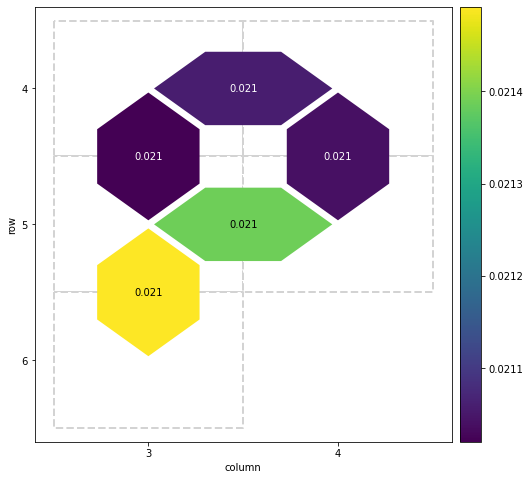

In [14]:
from cirq.experiments.xeb_fitting import fit_exponential_decays, exponential_decay
fidelities = fit_exponential_decays(fids)
heatmap_data = {}

for (_, _, pair), fidelity in fidelities.layer_fid.items():
    heatmap_data[pair] = 1.0 - fidelity

cirq.TwoQubitInteractionHeatmap(heatmap_data).plot();

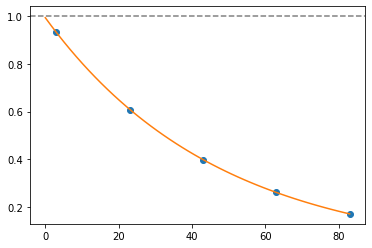

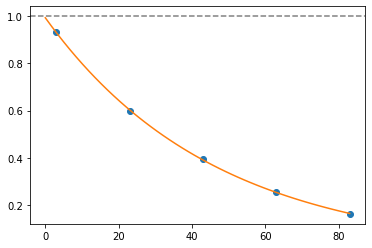

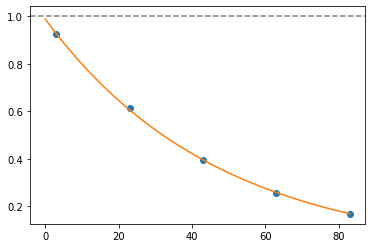

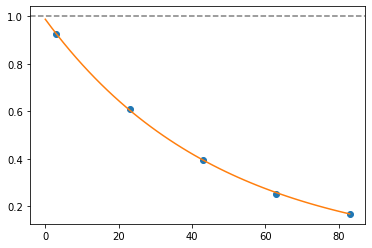

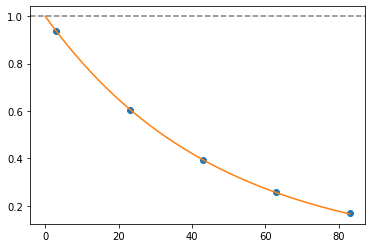

In [15]:
for i, record in fidelities.iterrows():
    plt.axhline(1, color='grey', ls='--')
    plt.plot(record['cycle_depths'], record['fidelities'], 'o')
    xx = np.linspace(0, np.max(record['cycle_depths']))
    plt.plot(xx, exponential_decay(xx, a=record['a'], layer_fid=record['layer_fid']))
    plt.show()

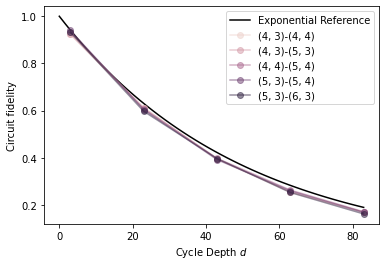

In [16]:
import seaborn as sns

# Give each pair its own color
colors = sns.cubehelix_palette(n_colors=graph.number_of_edges())
colors = dict(zip(graph.edges, colors))

# Exponential reference
xx = np.linspace(0, fids['cycle_depth'].max())
plt.plot(xx, (1-5e-3)**(4*xx), label=r'Exponential Reference', color='black')

# Plot each pair
def _p(fids):
    q0, q1 = fids.name
    plt.plot(fids['cycle_depth'], fids['fidelity'], 
             'o-', label=f'{q0}-{q1}', color=colors[fids.name], alpha=0.5)
fids.groupby('pair').apply(_p)

plt.ylabel('Circuit fidelity')
plt.xlabel('Cycle Depth $d$')
plt.legend(loc='best')

In [17]:
import multiprocessing
pool = multiprocessing.get_context('spawn').Pool()

In [18]:
# optimize PhasedFSimParameters
from cirq.experiments.xeb_fitting import (
    parameterize_circuit, 
    characterize_phased_fsim_parameters_with_xeb_by_pair, 
    SqrtISwapXEBOptions,
)

# Set which angles we want to characterize (all)
options = SqrtISwapXEBOptions(
    characterize_theta = True,
    characterize_zeta = True,
    characterize_chi = True,
    characterize_gamma = True,
    characterize_phi = True
)
# Parameterize the sqrt(iswap)s in our circuit library
pcircuits = [parameterize_circuit(circuit, options) for circuit in circuit_library]

# Run the characterization loop
characterization_result = characterize_phased_fsim_parameters_with_xeb_by_pair(
    sampled_df,
    pcircuits,
    cycle_depths,
    options,
    pool=pool,
    # ease tolerance so it converges faster:
    fatol=1e-2, 
    xatol=1e-2
)

In [19]:
characterization_result.final_params

{(cirq.GridQubit(4, 3), cirq.GridQubit(5, 3)): {'theta': -0.7558714713455051,
  'zeta': 0.02926910281313748,
  'chi': -0.032691353794460226,
  'gamma': 0.029799320039838886,
  'phi': -0.06422132667245813},
 (cirq.GridQubit(4, 3), cirq.GridQubit(4, 4)): {'theta': -0.8152431960769664,
  'zeta': -0.07212969420906544,
  'chi': -0.042954989029739606,
  'gamma': 0.016394657440937082,
  'phi': 0.03915550028144834},
 (cirq.GridQubit(4, 4), cirq.GridQubit(5, 4)): {'theta': -0.7834518389813017,
  'zeta': 0.037777558839736665,
  'chi': -0.01940813660114829,
  'gamma': 0.007309143379447065,
  'phi': 0.030778690476658287},
 (cirq.GridQubit(5, 3), cirq.GridQubit(6, 3)): {'theta': -0.757704513026906,
  'zeta': 0.0035450595613311267,
  'chi': -0.04632987218578745,
  'gamma': 0.0013365327861129472,
  'phi': 0.02173148674814844},
 (cirq.GridQubit(5, 3), cirq.GridQubit(5, 4)): {'theta': -0.8303980880094206,
  'zeta': 0.10252512038356737,
  'chi': -0.07018624525131535,
  'gamma': -0.012920506288228786,
  

In [21]:
from cirq.experiments.xeb_fitting import before_and_after_characterization
before_after_df = before_and_after_characterization(fids, characterization_result)
before_after_df

,layer_i,pair_i,a_0,layer_fid_0,cycle_depths_0,fidelities_0,a_std_0,layer_fid_std_0,a_c,layer_fid_c,cycle_depths_c,fidelities_c,a_std_c,layer_fid_std_c,characterized_angles,theta,zeta,chi,gamma,phi
pair,,,,,,,,,,,,,,,,,,,,
"((4, 4), (5, 4))",0,0,0.993921,0.978960,"[3, 23, 43, 63, 83]","[0.9338155365270592, 0.606772906157479, 0.3975...",0.002440,0.000095,1.0,0.979487,"[3, 23, 43, 63, 83]","[0.9389302341888561, 0.622886857049232, 0.4132...",0.011962,0.000452,"{'theta': -0.7834518389813017, 'zeta': 0.03777...",-0.783452,0.037778,-0.019408,0.007309,0.030779
"((5, 3), (6, 3))",0,1,0.993598,0.978509,"[3, 23, 43, 63, 83]","[0.9323598788950432, 0.5971814786155977, 0.396...",0.005410,0.000213,1.0,0.978780,"[3, 23, 43, 63, 83]","[0.9287265479188483, 0.6220767641098226, 0.423...",0.031506,0.001222,"{'theta': -0.757704513026906, 'zeta': 0.003545...",-0.757705,0.003545,-0.046330,0.001337,0.021731
"((4, 3), (5, 3))",1,0,0.987740,0.978979,"[3, 23, 43, 63, 83]","[0.9241387305902082, 0.6122250284681946, 0.394...",0.004639,0.000181,1.0,0.979362,"[3, 23, 43, 63, 83]","[0.9419256462245404, 0.5996566058168395, 0.443...",0.036399,0.001382,"{'theta': -0.7558714713455051, 'zeta': 0.02926...",-0.755871,0.029269,-0.032691,0.029799,-0.064221
"((4, 3), (4, 4))",2,0,0.987398,0.978942,"[3, 23, 43, 63, 83]","[0.9243423804735154, 0.6096047809039231, 0.396...",0.004264,0.000166,1.0,0.981790,"[3, 23, 43, 63, 83]","[0.9174128525204155, 0.7092510096438316, 0.487...",0.052382,0.001824,"{'theta': -0.8152431960769664, 'zeta': -0.0721...",-0.815243,-0.072130,-0.042955,0.016395,0.039156
"((5, 3), (5, 4))",3,0,1.000000,0.978612,"[3, 23, 43, 63, 83]","[0.9396607046556869, 0.6044990376758134, 0.392...",0.004132,0.000161,1.0,0.980823,"[3, 23, 43, 63, 83]","[0.9525084170391354, 0.7007319948718523, 0.412...",0.053917,0.001943,"{'theta': -0.8303980880094206, 'zeta': 0.10252...",-0.830398,0.102525,-0.070186,-0.012921,0.004220


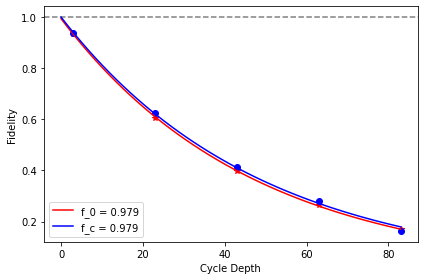

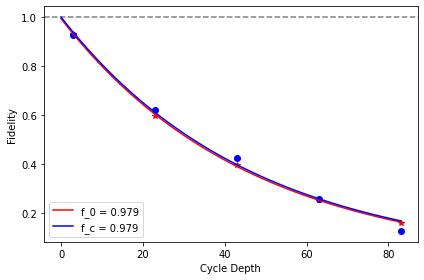

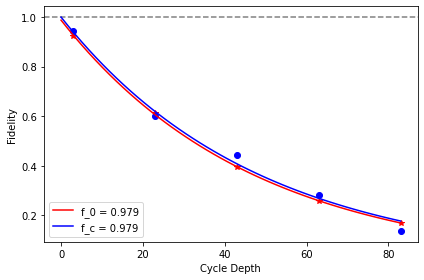

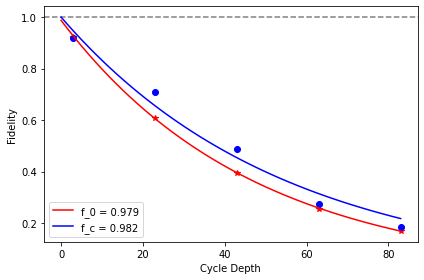

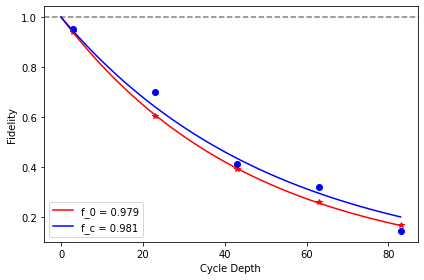

In [22]:
for i, row in before_after_df.iterrows():
    plt.axhline(1, color='grey', ls='--')
    plt.plot(row['cycle_depths_0'], row['fidelities_0'], '*', color='red')
    plt.plot(row['cycle_depths_c'], row['fidelities_c'], 'o', color='blue')

    xx = np.linspace(0, np.max(row['cycle_depths_0']))
    plt.plot(xx, exponential_decay(xx, a=row['a_0'], layer_fid=row['layer_fid_0']), 
             color='red', label=f'f_0 = {row["layer_fid_0"]:.3f}')
    plt.plot(xx, exponential_decay(xx, a=row['a_c'], layer_fid=row['layer_fid_c']),
             color='blue', label=f'f_c = {row["layer_fid_c"]:.3f}')

    plt.xlabel('Cycle Depth')
    plt.ylabel('Fidelity')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()